In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Read ORF and CRISPR cosine similarities

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')
crispr_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_crispr.parquet')

In [3]:
def check_connections(
    genes,
    orf_similarity_percentile_df,
    crispr_similarity_percentile_df,
    connections_df,
):
    genes.sort()
    for i in range(len(genes) - 1):
        gene_1 = genes[i]
        for j in range(i + 1, len(genes)):
            gene_2 = genes[j]
            df = pd.DataFrame(
                {
                    "gene_1": gene_1,
                    "gene_2": gene_2,
                    "Present_and_replicable_in_ORF": False,
                    "ORF_cosine_similarity_percentile": np.nan,
                    "Present_and_replicable_in_CRISPR": False,
                    "CRISPR_cosine_similarity_percentile": np.nan,
                },
                index=[0],
            )
            if (
                gene_1 in orf_similarity_percentile_df.index
                and gene_2 in orf_similarity_percentile_df.columns
            ):
                df["Present_and_replicable_in_ORF"] = True
                df["ORF_cosine_similarity_percentile"] = orf_similarity_percentile_df.loc[gene_1, gene_2]
            if (
                gene_1 in crispr_similarity_percentile_df.index
                and gene_2 in crispr_similarity_percentile_df.columns
            ):
                df["Present_and_replicable_in_CRISPR"] = True
                df["CRISPR_cosine_similarity_percentile"] = crispr_similarity_percentile_df.loc[
                    gene_1, gene_2
                ]

            connections_df = pd.concat([connections_df, df], ignore_index=True, axis=0)

    connections_df.drop_duplicates(
        subset=["gene_1", "gene_2"], inplace=True, keep="first"
    )

    return connections_df

In [4]:
connections_df = pd.DataFrame()

Check previous connections that we were interested in

In [5]:
previous_gene_lists = [
    ["ZBTB16", "SLC39A1"],
    ["RAB30", "NAT14"],
    ["MYT1", "RNF41", "INSYN1"],
    ["PIK3R3", "RAB40A", "RAB40B", "RAB40C", "INSYN1", "XLOC_l2_008134"],
    ["BICD2", "HOOK1", "HOOK2", "SPDL1", "NDEL1", "NDE1", "PAFAH1B1"],
    ["TRAF2", "STK3", "YAP1", "WWTR1", "STK11"],
    ["YAP1", "VCAM1", "FOXG1", "TEX45", "FOXP3", "TFAP2A", "EBF1", "LCOR", "CORO2A", "CORO2B", "GMIP"],
    ["GPR176", "TSC22D1", "DPAT1", "CHRM4", "CDC42SE2", "CDC25C", "MYT1", "MAP4K4"],
    ["ECH1", "UQCRFS1", "SARS2"],
    ["POLRID", "SPATA25", "CAMK2A", "GJB2", "ATG7", "MGLL", "CCL14", "PNPLA4", "EML1", "PER1", "SLC39A1"],
    ["FOXO3", "TGFB1"]
]

In [6]:
# Phenotypic Activity
orf_ph_activity = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
)

orf_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Approved_Symbol", "Metadata_Symbol"],
)

orf_ph_activity = orf_ph_activity.merge(orf_metadata, on="Metadata_JCP2022", how="left")

orf_ph_activity = orf_ph_activity.assign(
    Metadata_Gene_Symbol=lambda x: np.where(
        x.Metadata_Approved_Symbol.isna(), x.Metadata_Symbol, x.Metadata_Approved_Symbol
    )
)

crispr_ph_activity = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
)

crispr_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Approved_Symbol", "Metadata_Symbol"],
)

crispr_ph_activity = crispr_ph_activity.merge(
    crispr_metadata, on="Metadata_JCP2022", how="left"
)

crispr_ph_activity = crispr_ph_activity.assign(
    Metadata_Gene_Symbol=lambda x: np.where(
        x.Metadata_Approved_Symbol.isna(), x.Metadata_Symbol, x.Metadata_Approved_Symbol
    )
)

In [7]:
for genes in previous_gene_lists:
    previous = True
    connections_df = check_connections(genes, orf_similarity_percentile_df, crispr_similarity_percentile_df, connections_df)

Add all knowledge graph information

In [8]:
# The zip files should be stored in the ~/Downloads folder. 
# The zip files are available on google drive: 
#   https://drive.google.com/file/d/1E0C8w1I-zyS1hSHoTm9mC5PMzI7QLWY_/view?usp=drive_link for ORF
#   https://drive.google.com/file/d/1RZ2_vK6t2w14R6CFIfvo50kZbfdiW4Si/view?usp=drive_link for CRISPR.

knowledge_graph_orf = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_orf = pd.concat(
    [
        knowledge_graph_orf,
        knowledge_graph_orf.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_crispr = pd.read_csv(
    "~/Downloads/crispr_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_crispr = pd.concat(
    [
        knowledge_graph_crispr,
        knowledge_graph_crispr.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph = pd.concat(
    [knowledge_graph_orf, knowledge_graph_crispr], ignore_index=True
).drop_duplicates(subset=["gene_1", "gene_2"])

connections_df = connections_df.merge(
    knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

In [9]:
with pd.ExcelWriter("output/connections.xlsx") as writer:
    connections_df.to_excel(writer, index=False, sheet_name="all_connections")

/home/niranj/miniforge3/envs/similarity/lib/python3.10/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


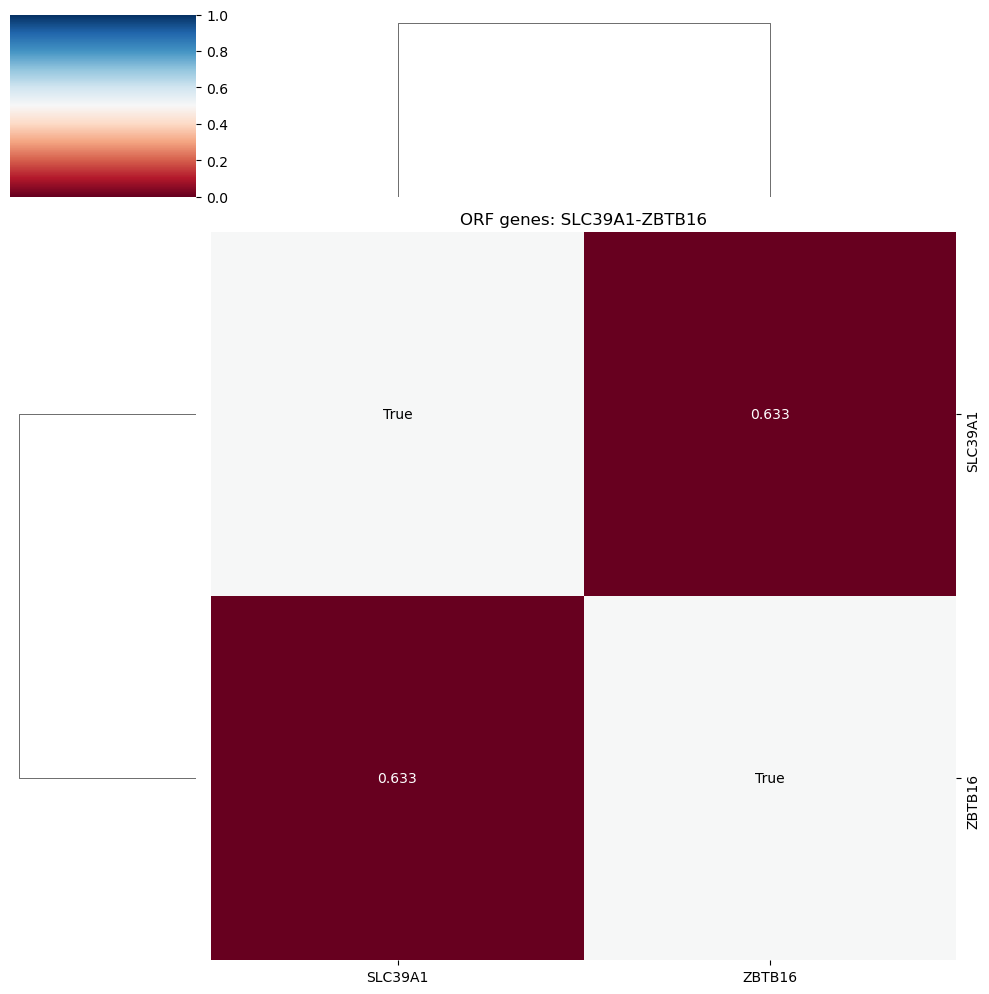

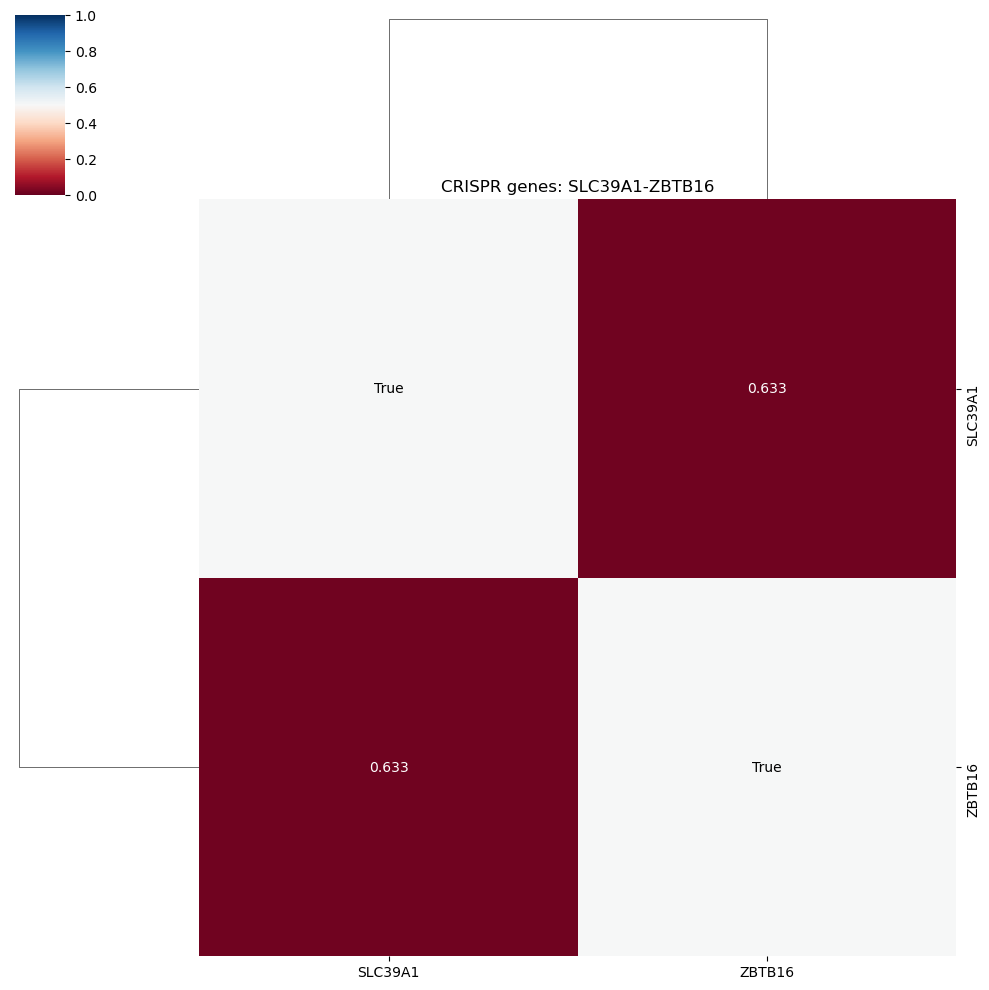

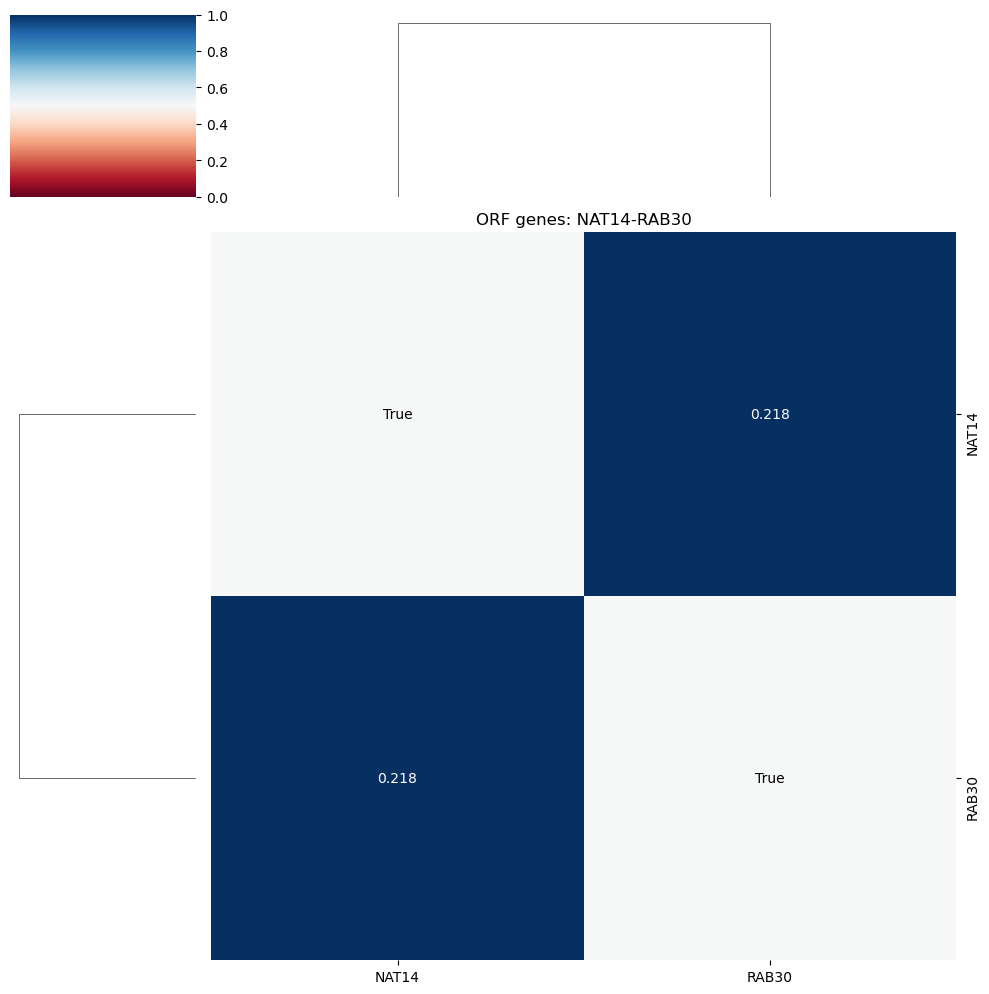

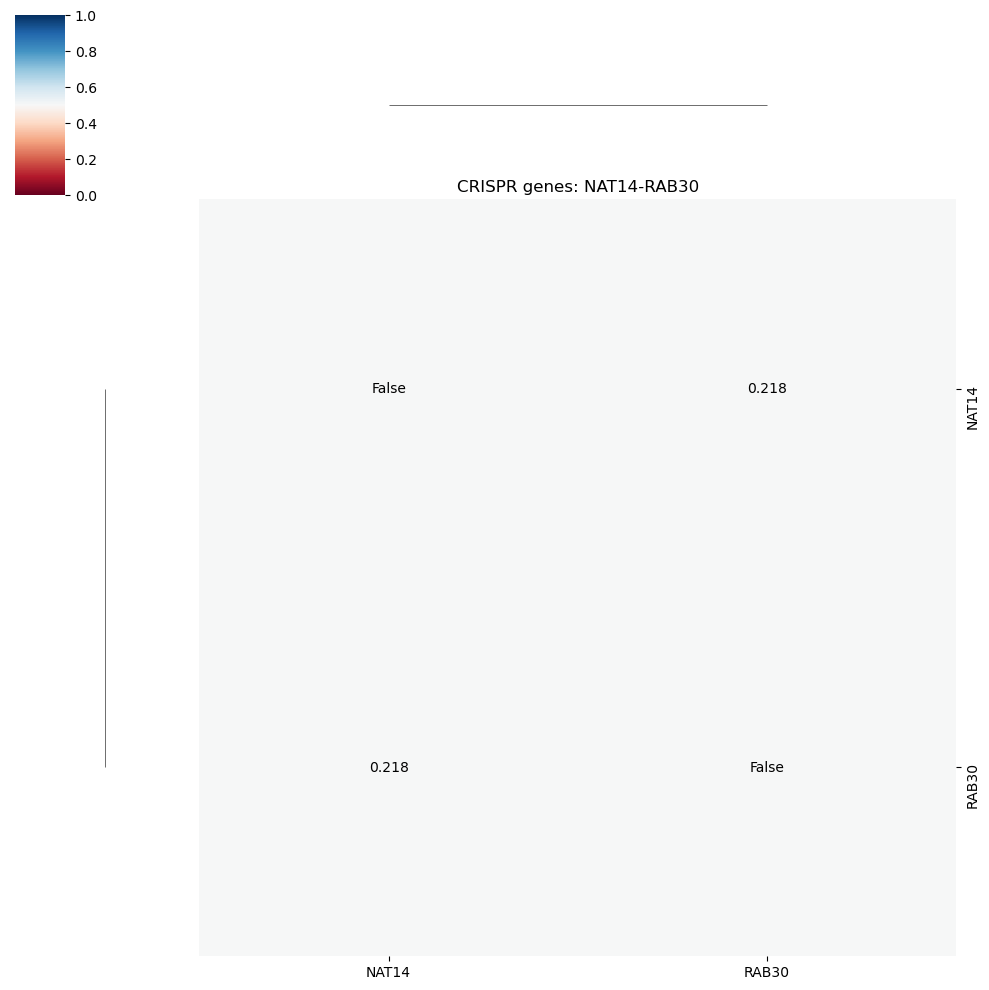

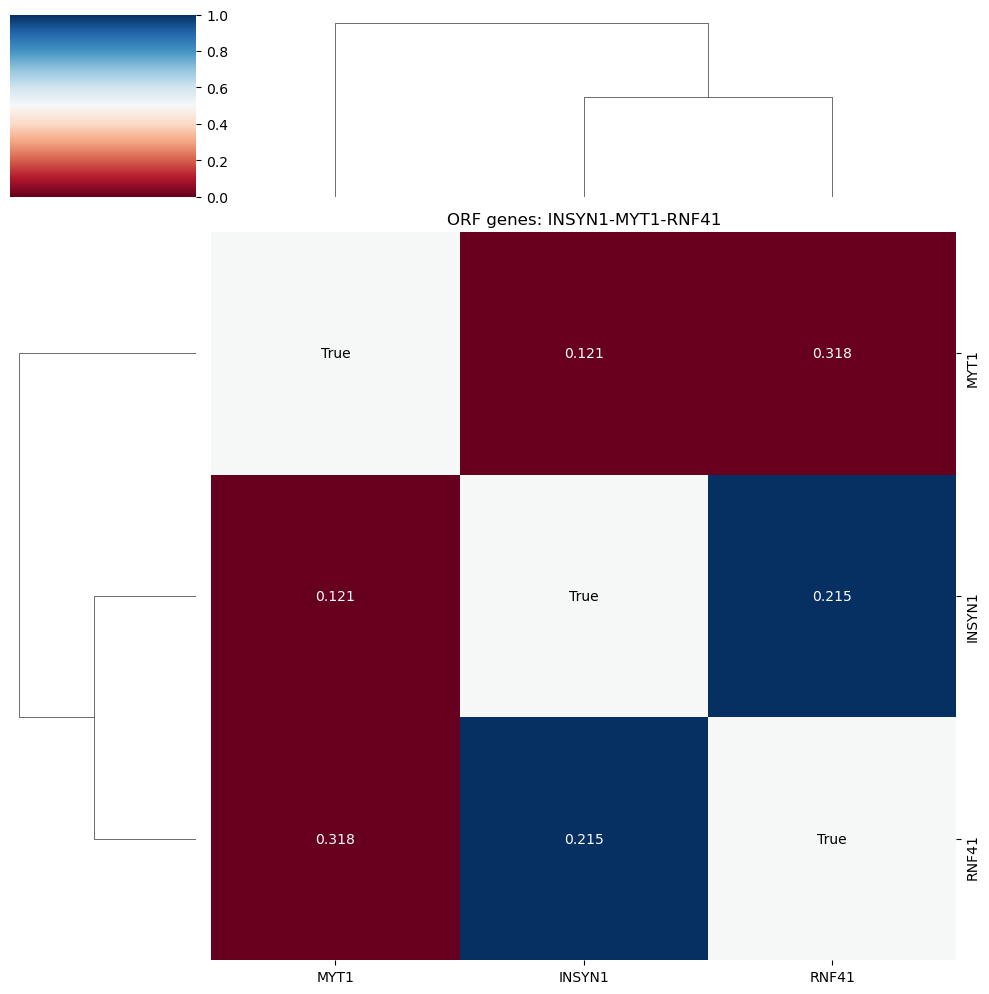

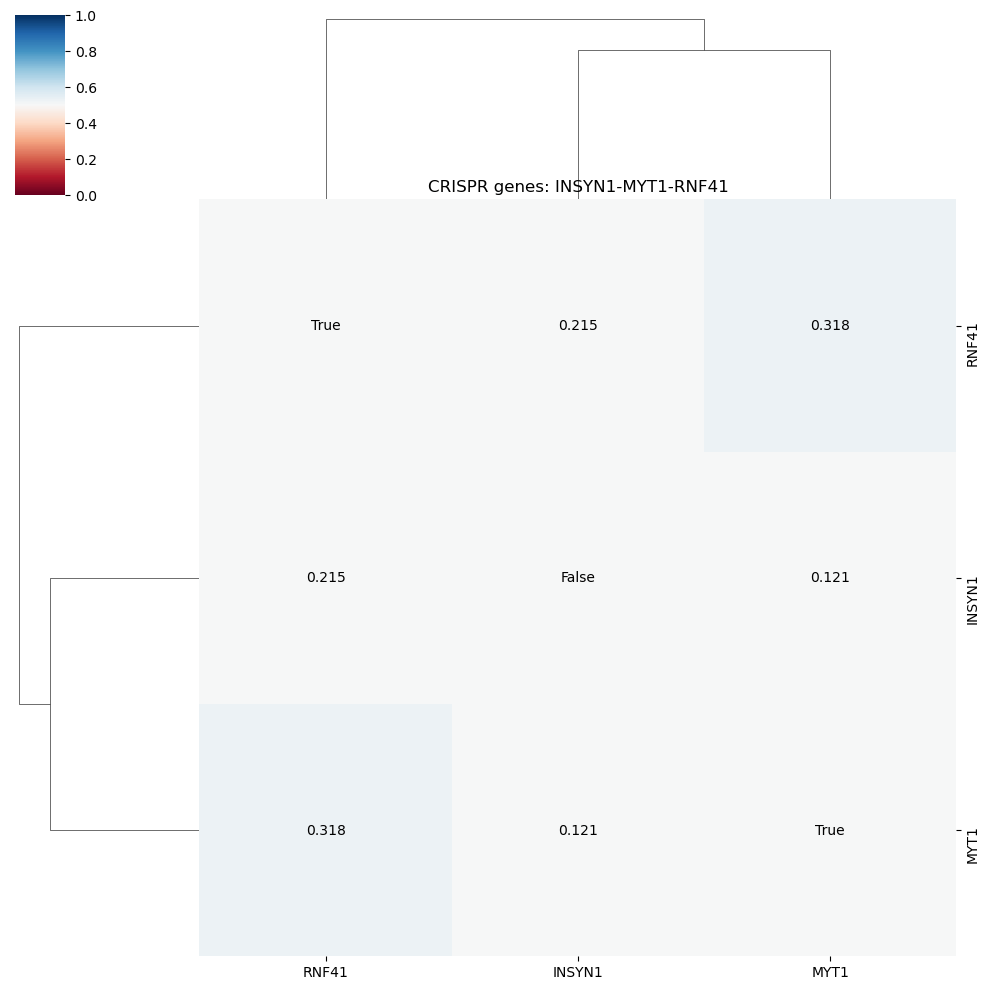

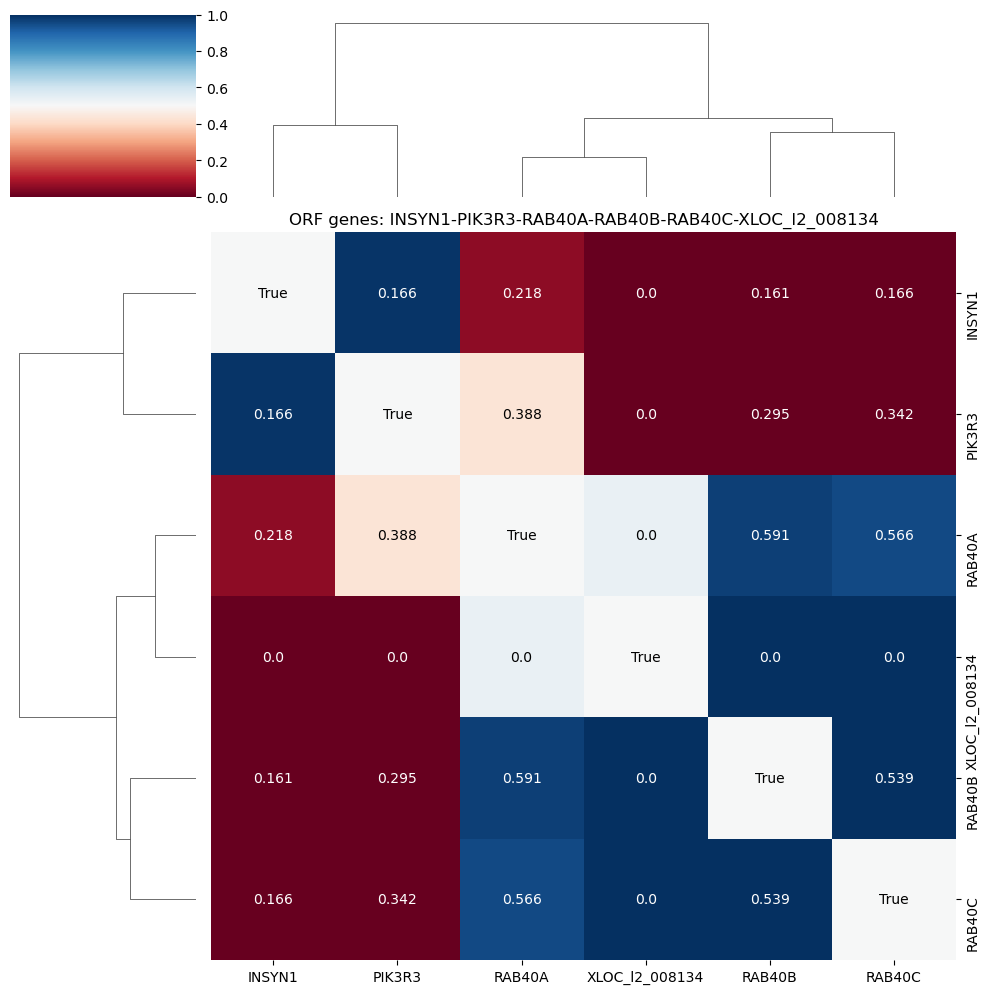

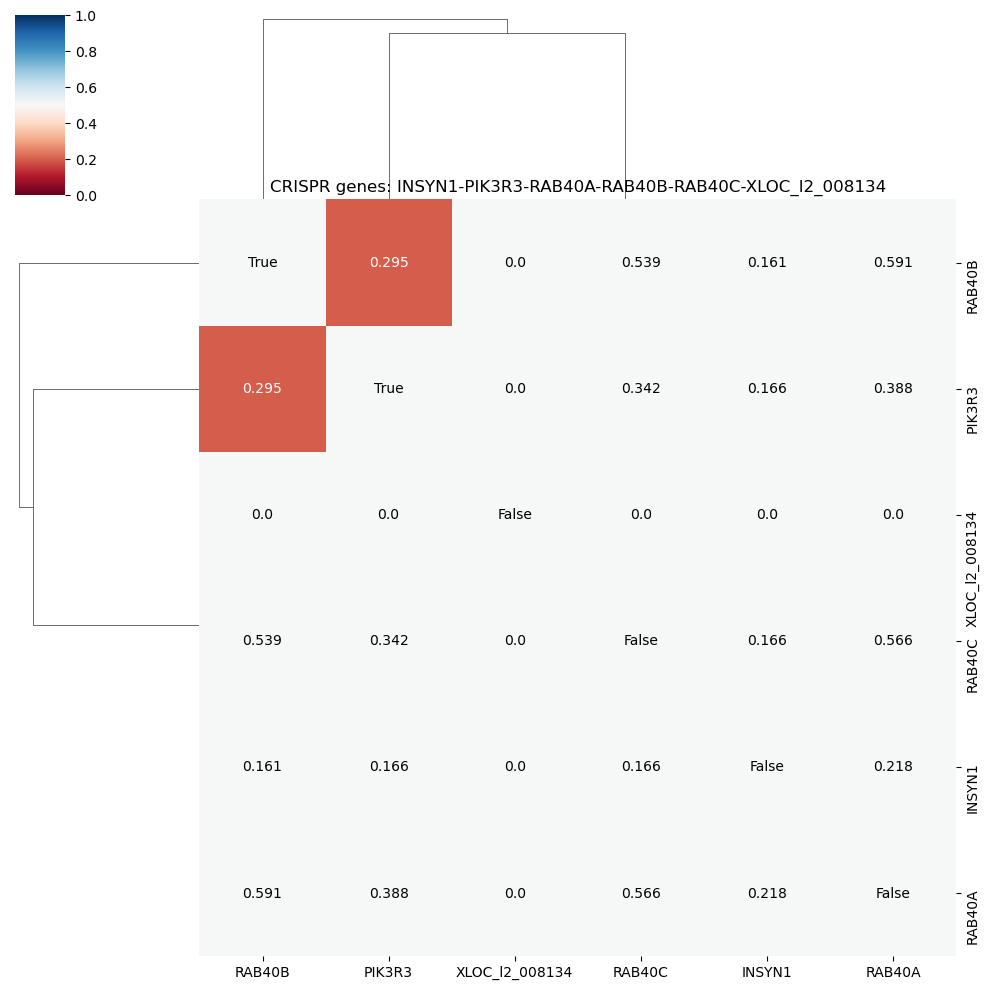

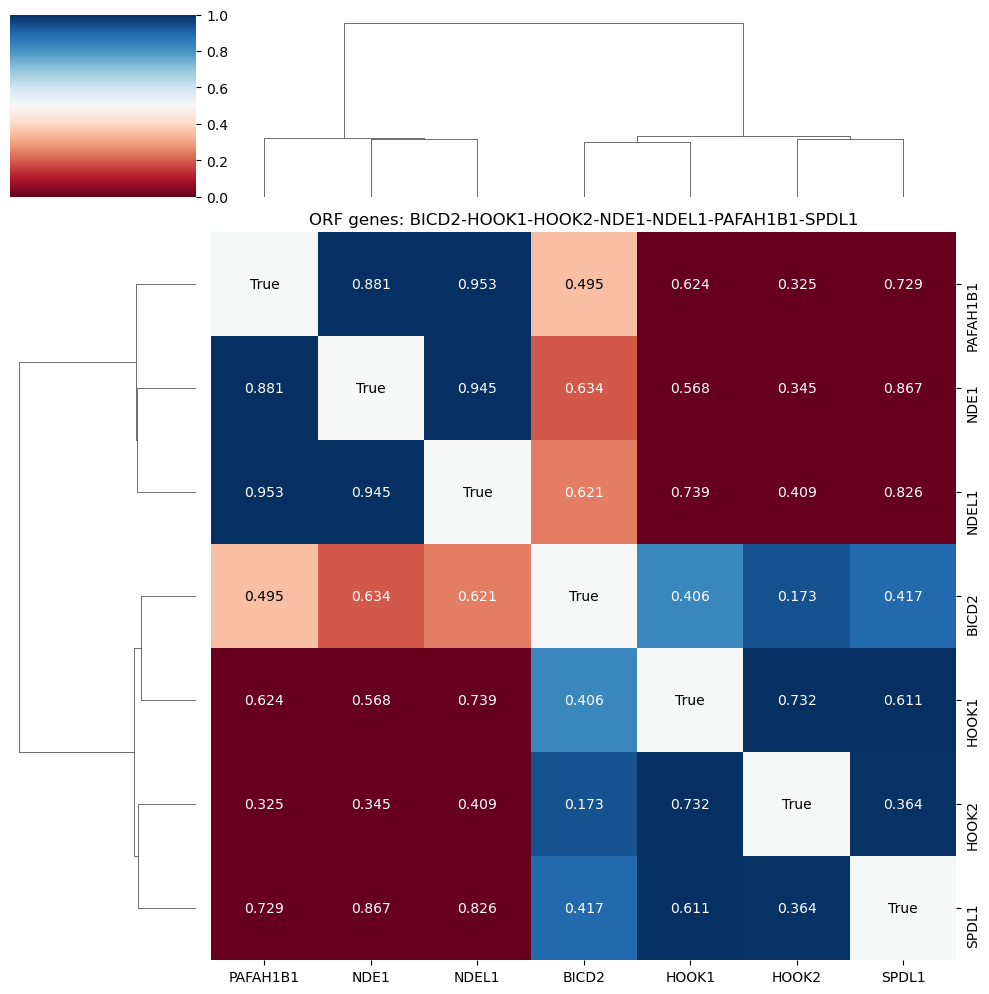

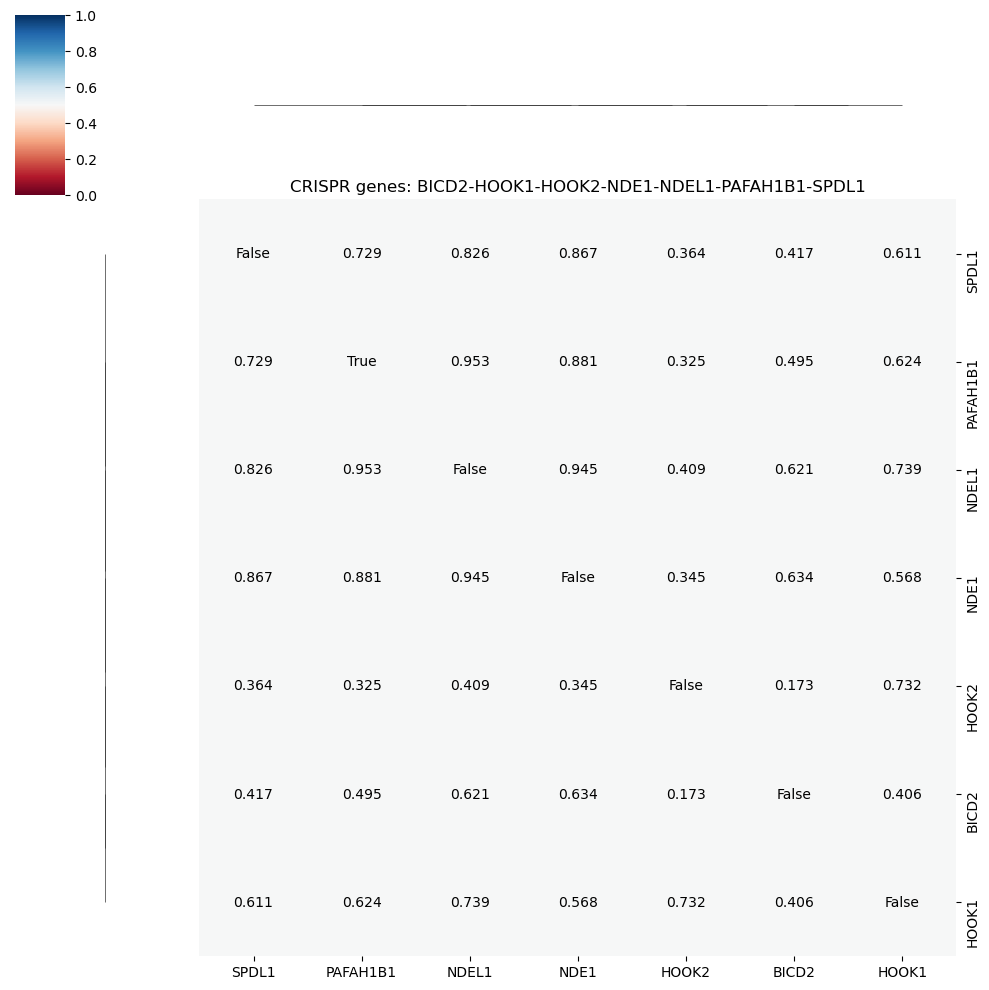

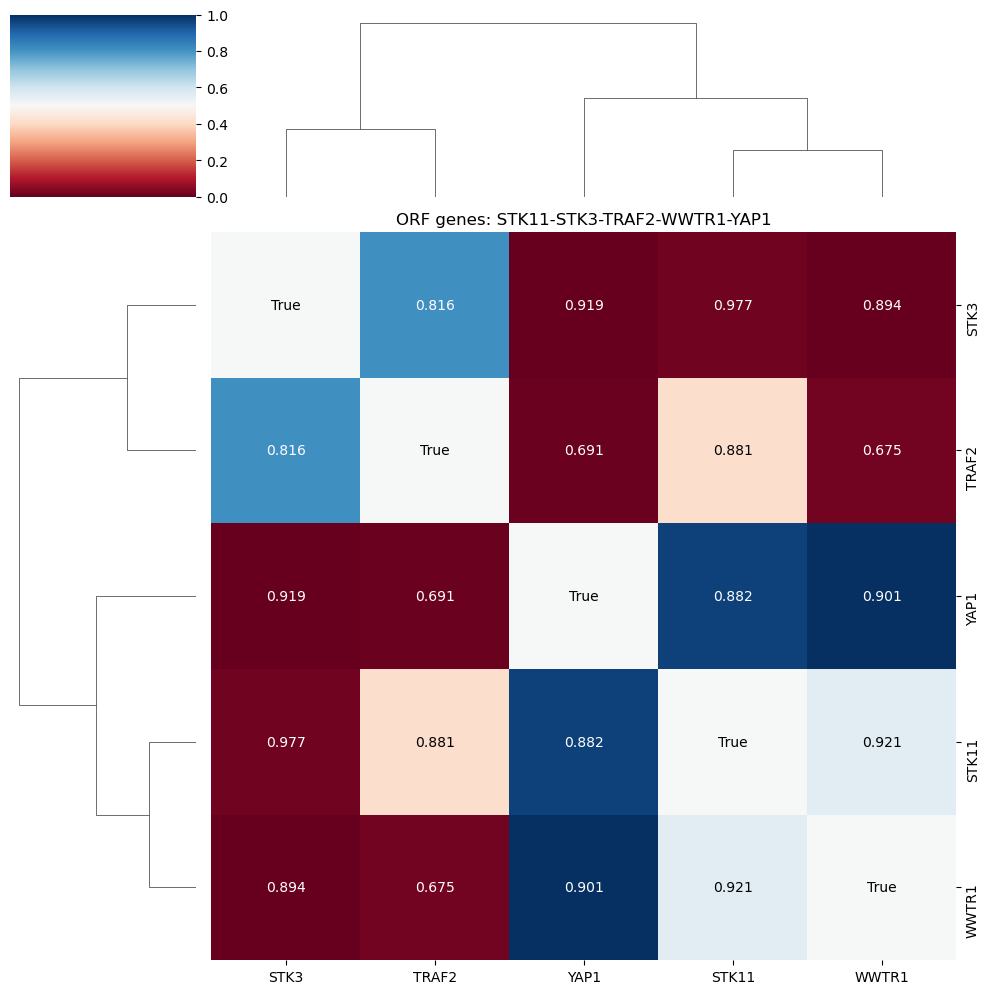

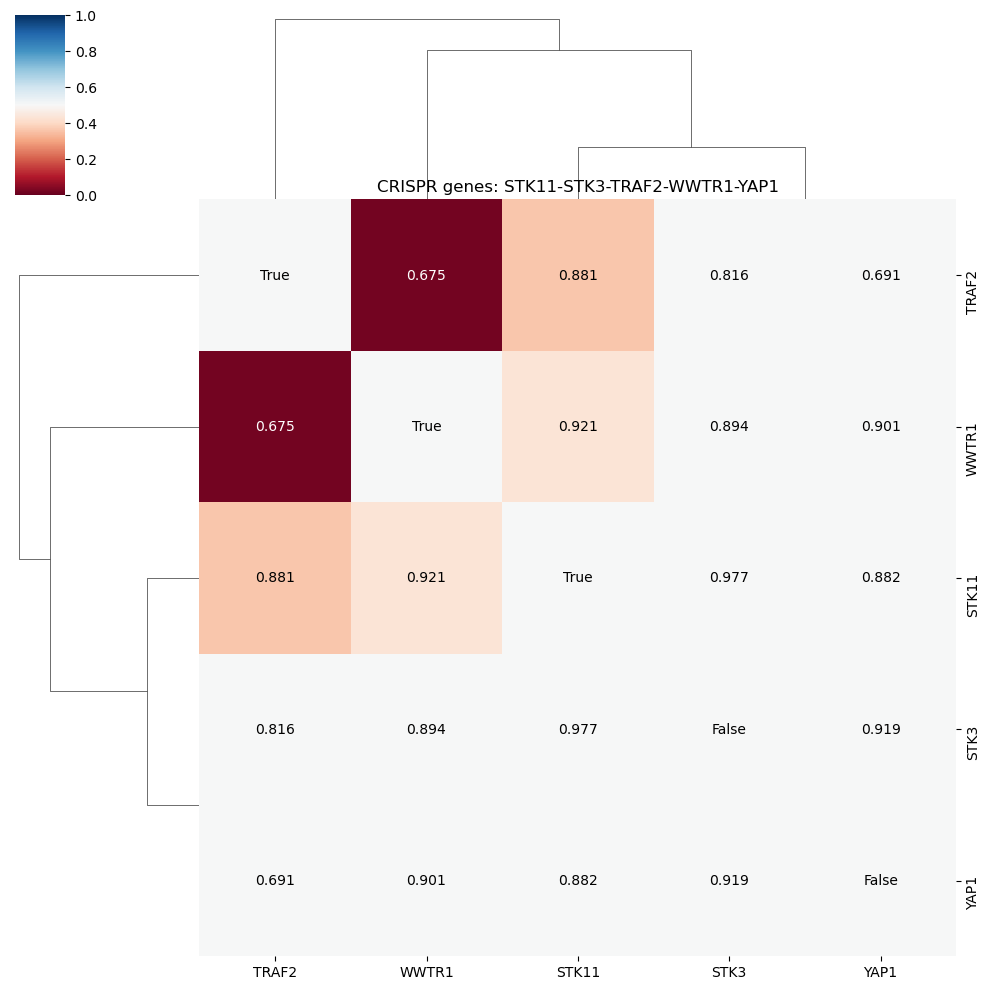

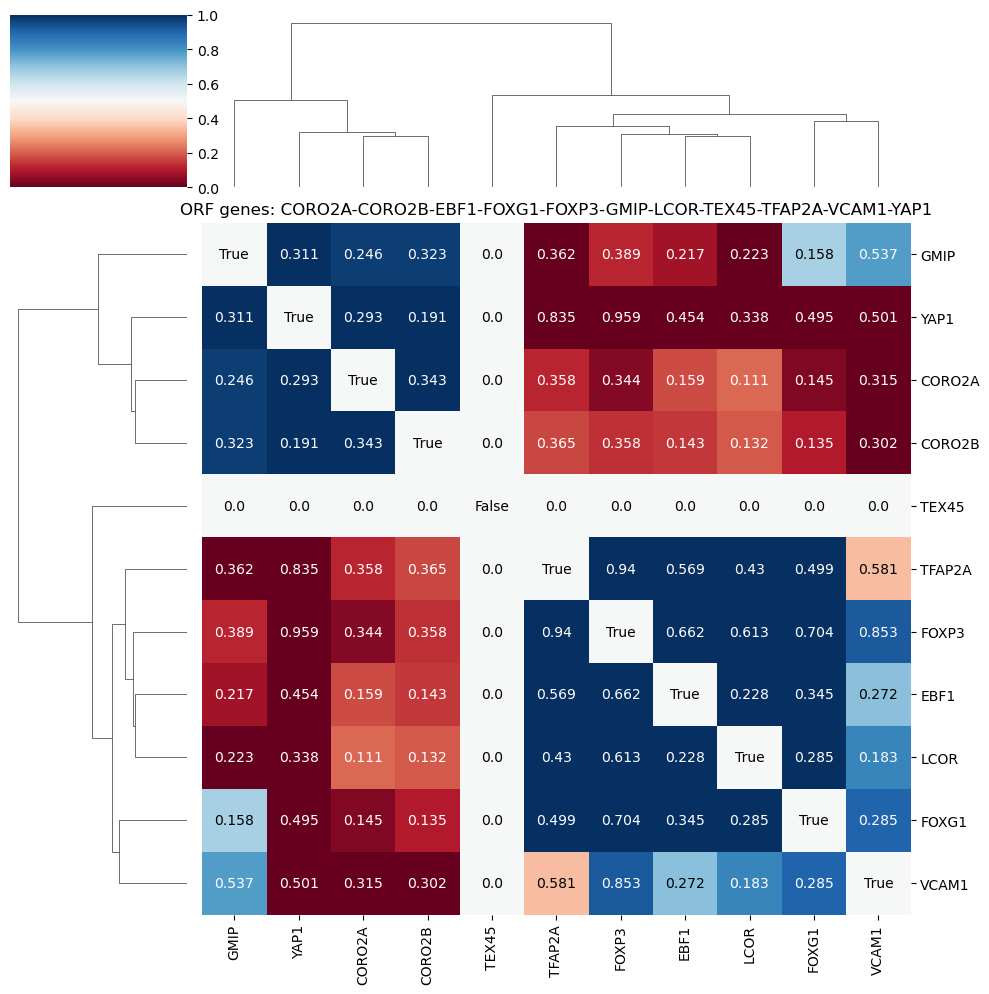

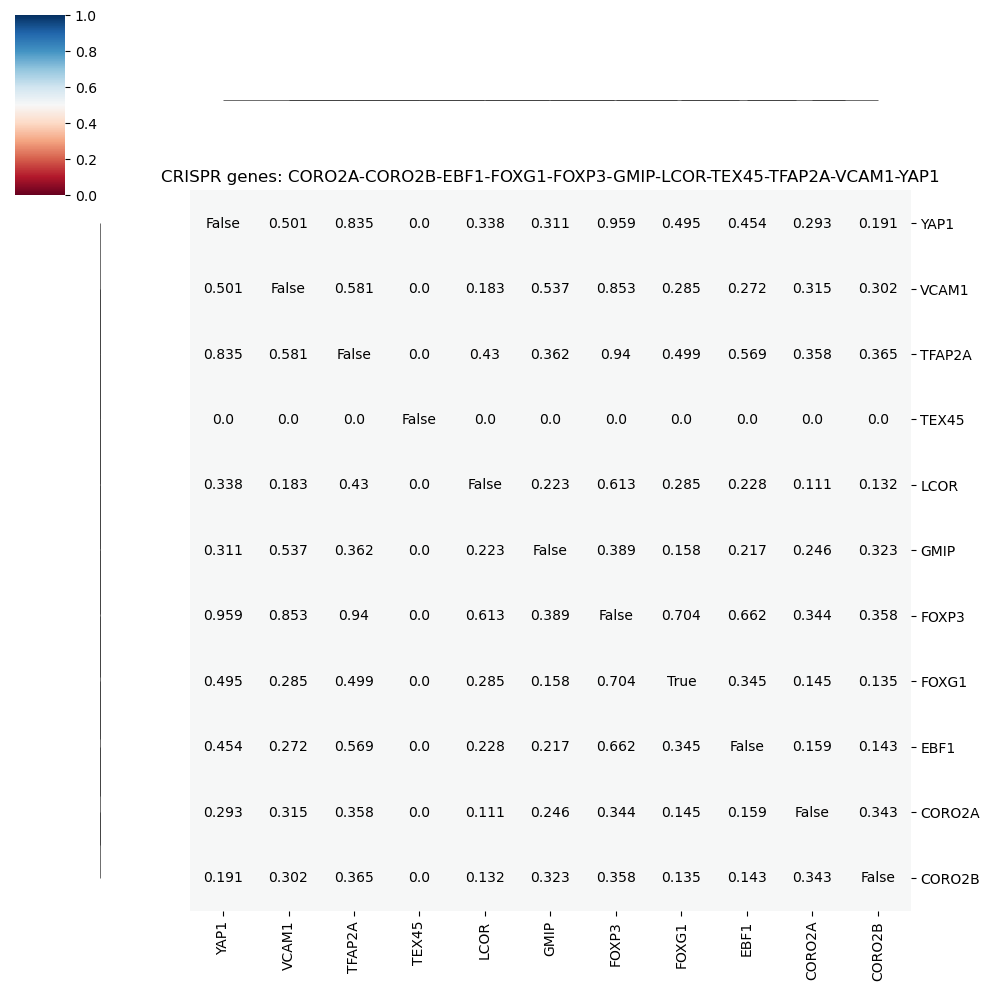

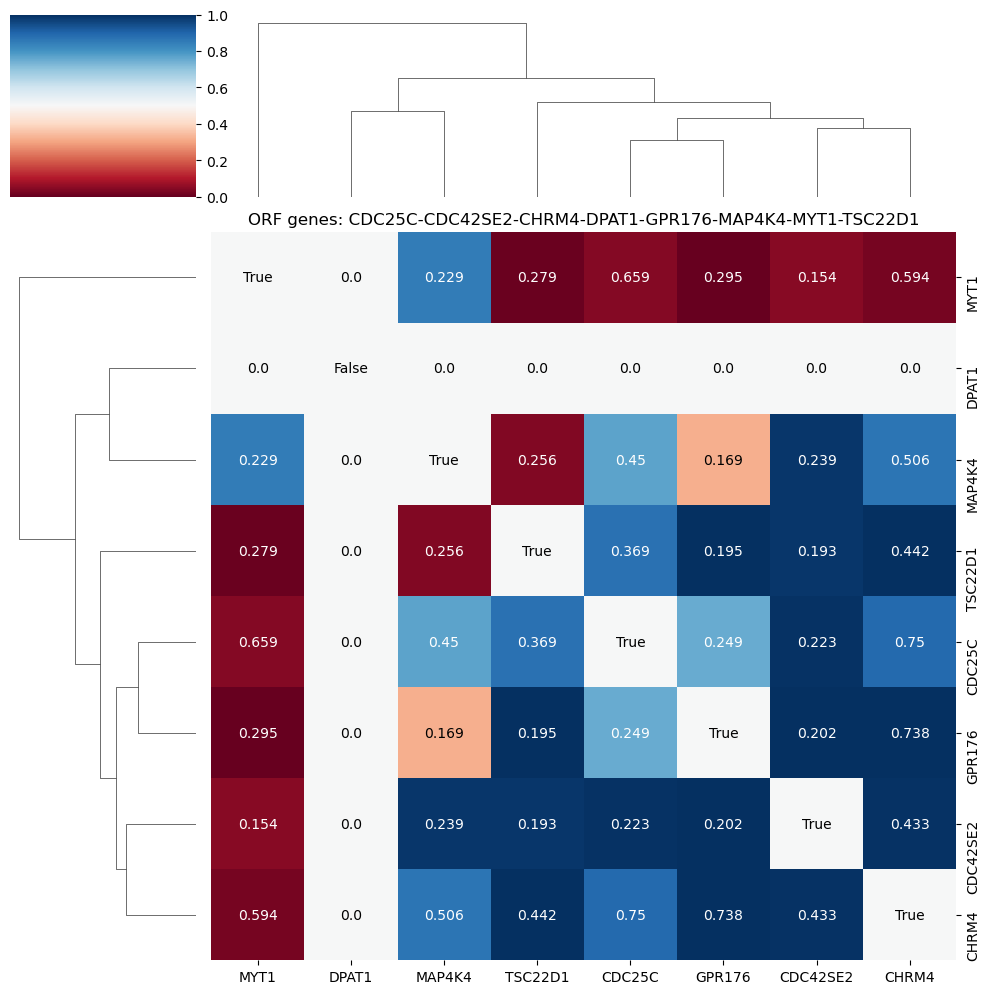

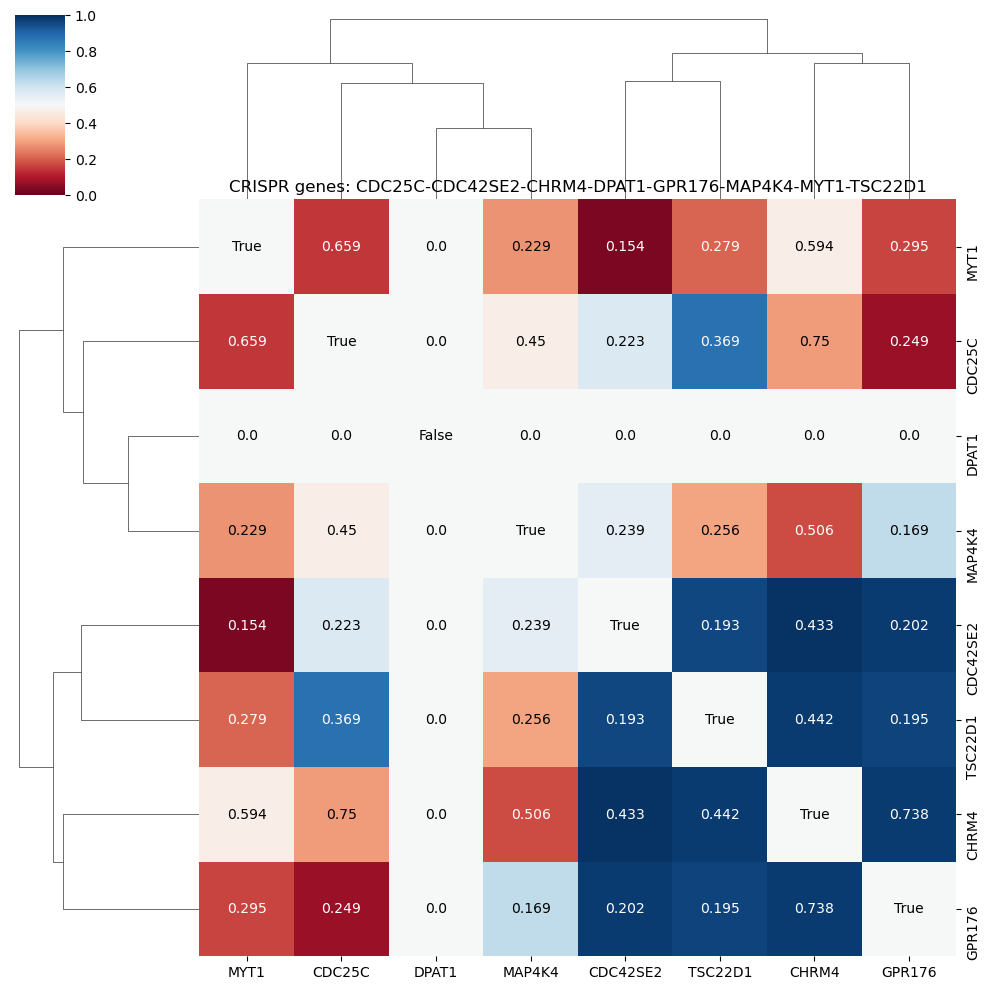

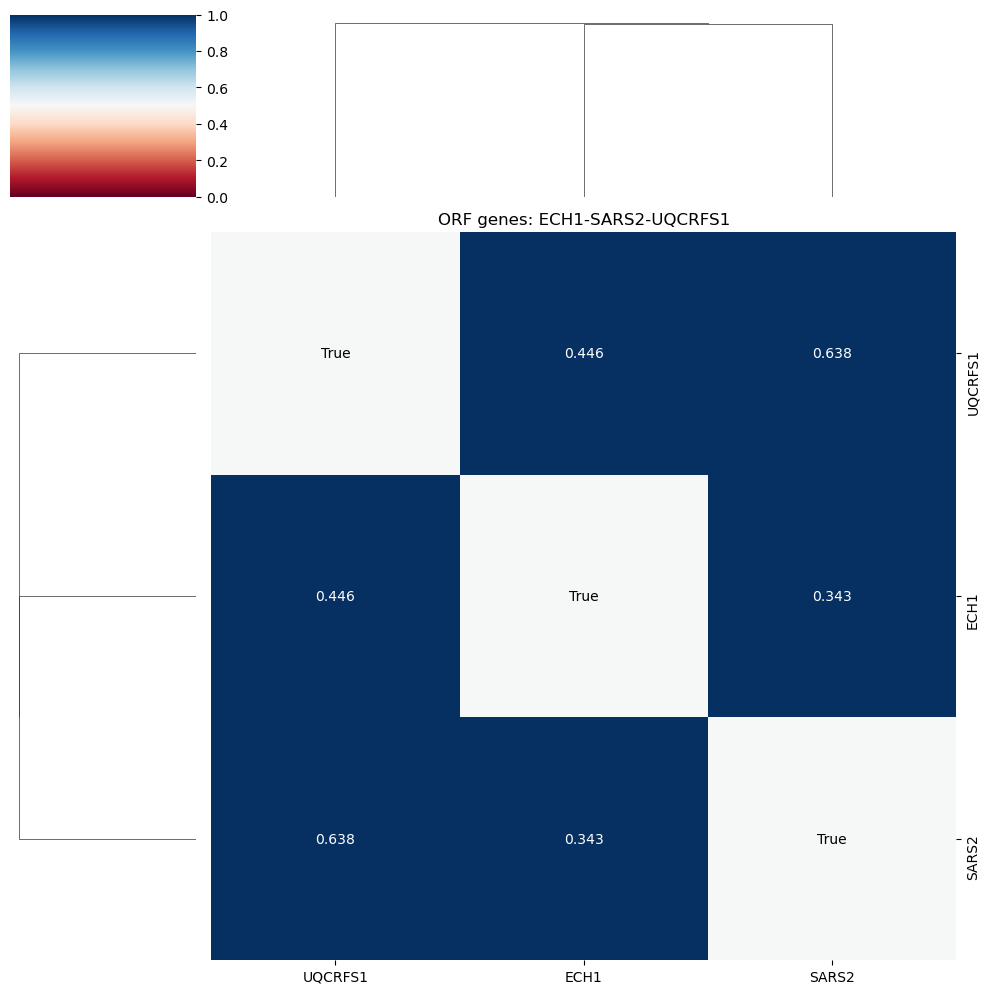

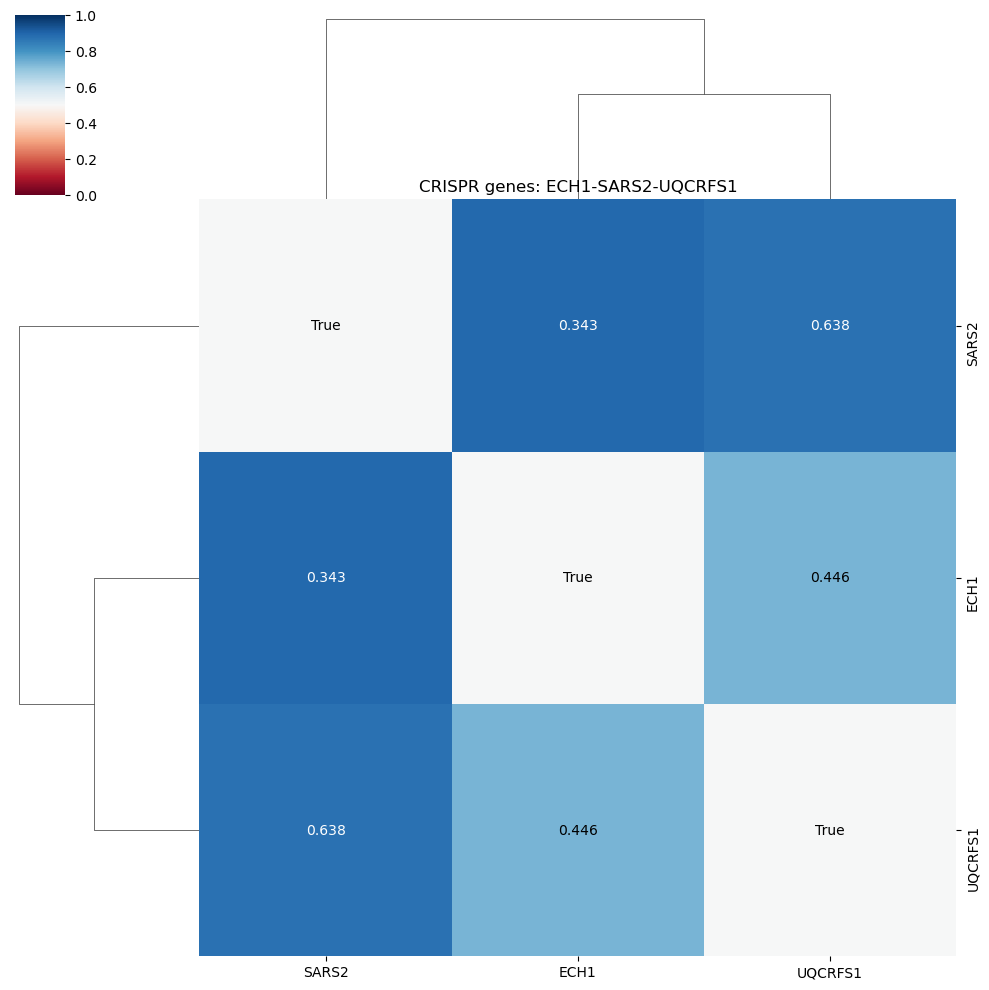

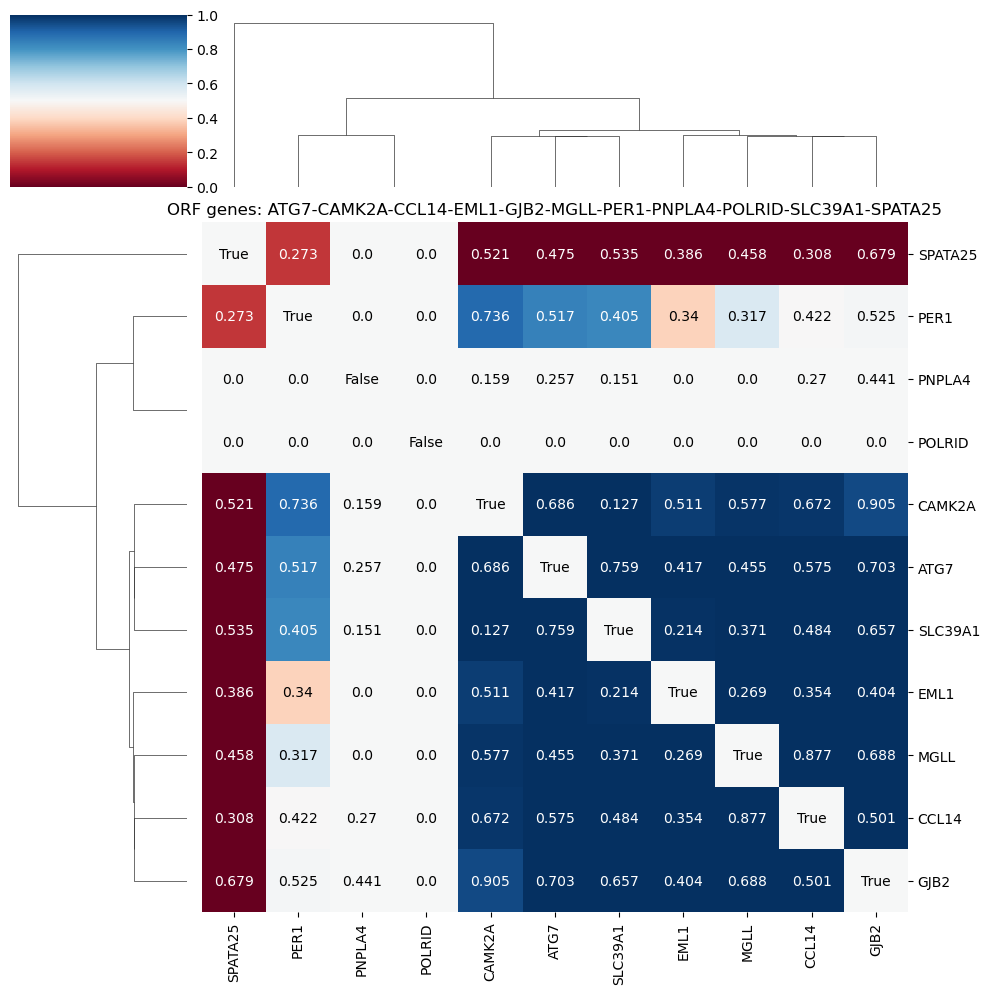

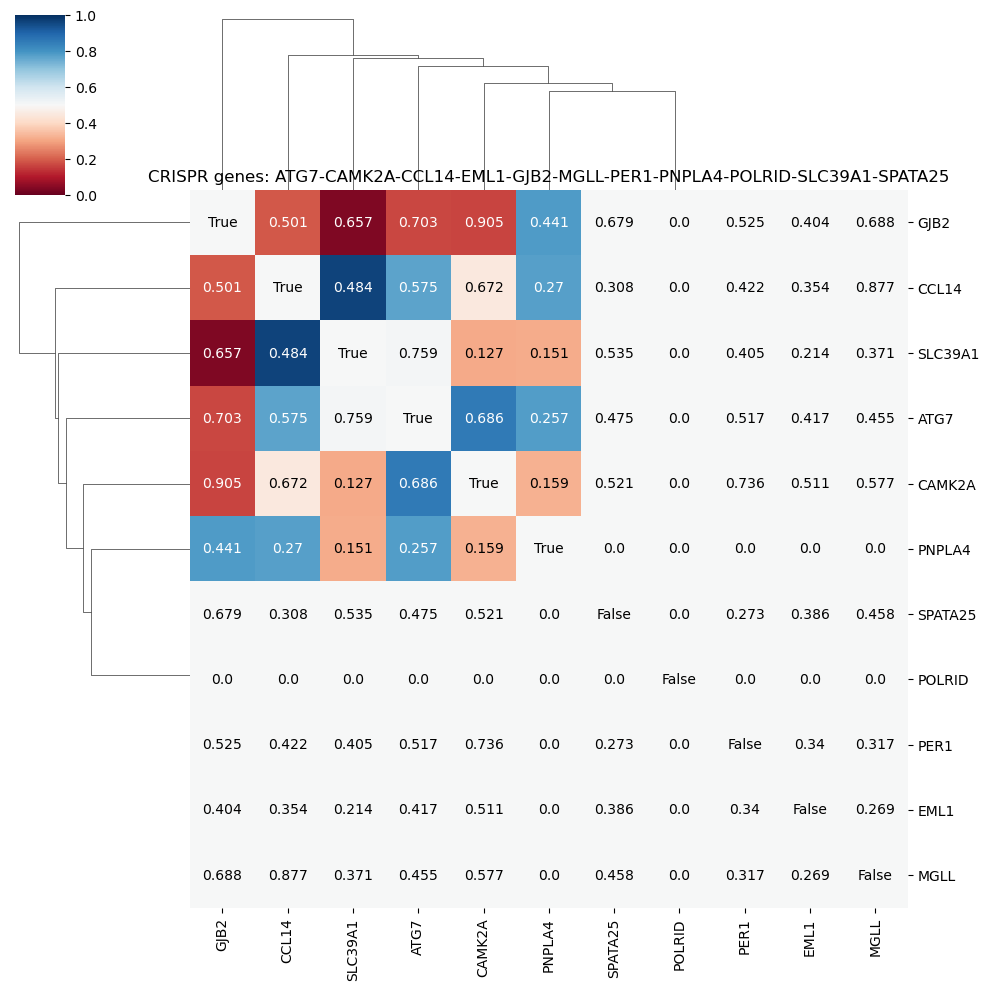

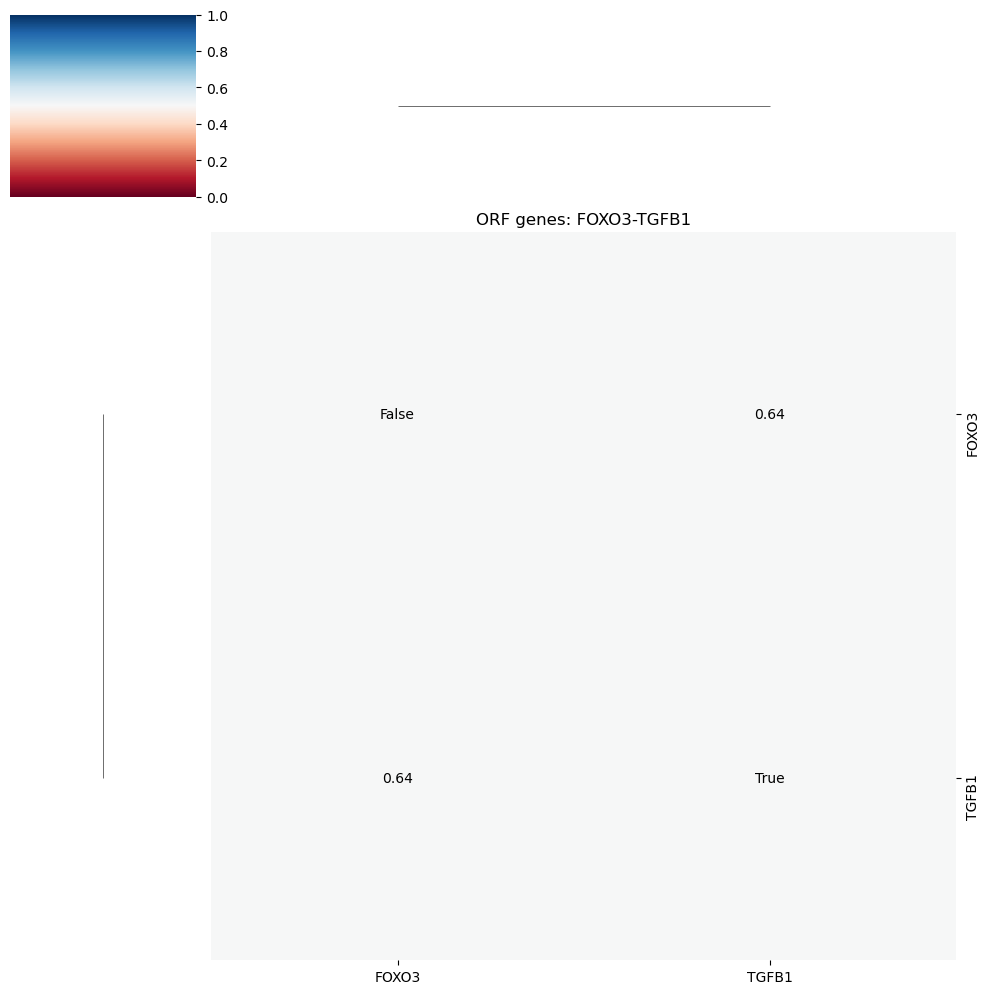

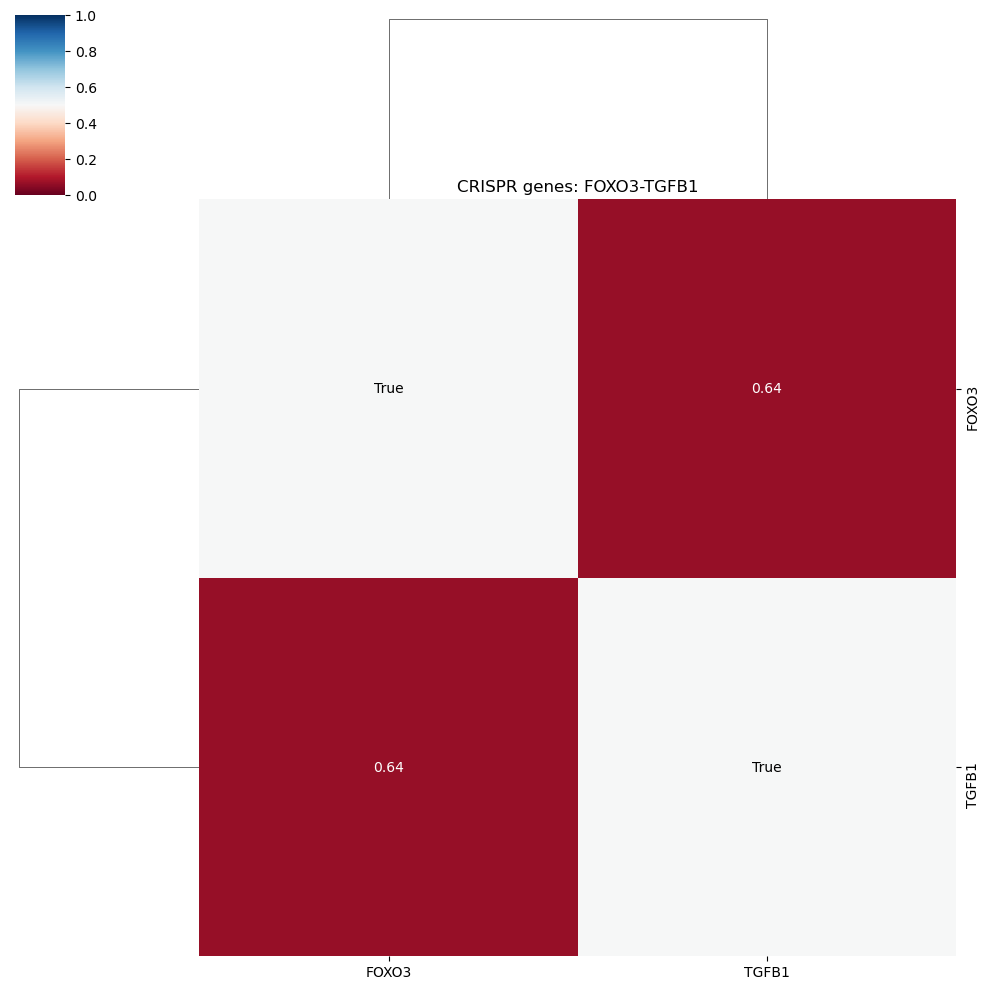

In [10]:
connections_trimmed_df = (
    connections_df[
        [
            "gene_1",
            "gene_2",
            "ORF_cosine_similarity_percentile",
            "CRISPR_cosine_similarity_percentile",
            "gene_mf",
            "gene_bp",
            "gene_pathway",
        ]
    ]
    .copy()
    .fillna(value={"ORF_cosine_similarity_percentile": 0.5, "CRISPR_cosine_similarity_percentile": 0.5})
    .fillna(0)
    .assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

orf_col = ["gene_1", "gene_2", "ORF_cosine_similarity_percentile"]
crispr_col = ["gene_1", "gene_2", "CRISPR_cosine_similarity_percentile"]
kg_col = ["gene_1", "gene_2", "gene_kg"]

for genes in previous_gene_lists:
    genes.sort()
    gene_names = "-".join(genes)
    df = pd.DataFrame(
        list(itertools.combinations(genes, 2)), columns=["gene_1", "gene_2"]
    )
    plotting_df = (
        df.merge(connections_trimmed_df, how="left", on=["gene_1", "gene_2"])
    )
    plotting_df = pd.concat(
        [
            plotting_df,
            plotting_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
        ],
        ignore_index=True,
    )

    ### ORF similarity matrix

    orf_values = pd.pivot(
        plotting_df[orf_col],
        index="gene_1",
        columns="gene_2",
        values="ORF_cosine_similarity_percentile",
    ).values
    np.fill_diagonal(orf_values, 0.5)
    orf_df = pd.DataFrame(orf_values, columns=genes, index=genes)

    ### CRISPR similarity matrix

    crispr_values = pd.pivot(
        plotting_df[crispr_col],
        index="gene_1",
        columns="gene_2",
        values="CRISPR_cosine_similarity_percentile",
    ).values
    np.fill_diagonal(crispr_values, 0.5)
    crispr_df = pd.DataFrame(crispr_values, columns=genes, index=genes)

    # Add phenotypic activity info and KG

    orf_kg_df = pd.DataFrame(
        pd.pivot(
            pd.concat(
                [
                    plotting_df[kg_col],
                    orf_ph_activity.query("Metadata_Gene_Symbol in @genes")
                    .groupby("Metadata_Gene_Symbol")
                    .below_corrected_p.apply(lambda x: x.any())
                    .reset_index()
                    .rename(
                        columns={
                            "Metadata_Gene_Symbol": "gene_1",
                            "below_corrected_p": "gene_kg",
                        }
                    )
                    .assign(gene_2=lambda x: x.gene_1),
                ],
                ignore_index=True,
            ),
            index="gene_1",
            columns="gene_2",
            values="gene_kg",
        ).values,
        columns=genes,
        index=genes,
    ).fillna(False)

    crispr_kg_df = pd.DataFrame(
        pd.pivot(
            pd.concat(
                [
                    plotting_df[kg_col],
                    crispr_ph_activity.query("Metadata_Gene_Symbol in @genes")
                    .groupby("Metadata_Gene_Symbol")
                    .below_corrected_p.apply(lambda x: x.any())
                    .reset_index()
                    .rename(
                        columns={
                            "Metadata_Gene_Symbol": "gene_1",
                            "below_corrected_p": "gene_kg",
                        }
                    )
                    .assign(gene_2=lambda x: x.gene_1),
                ],
                ignore_index=True,
            ),
            index="gene_1",
            columns="gene_2",
            values="gene_kg",
        ).values,
        columns=genes,
        index=genes,
    ).fillna(False)

    g = sns.clustermap(
        orf_df,
        cmap="RdBu",
        vmin=0,
        vmax=1,
    )

    ### Plot

    g.ax_heatmap.set_title(f"ORF genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(clustermap_df)):
        for j in range(len(clustermap_df.columns)):
            gene_1 = clustermap_df.index[i]
            gene_2 = clustermap_df.columns[j]
            orf_kg_gene_pair = orf_kg_df.loc[gene_1, gene_2]
            if gene_1 == gene_2 and orf_kg_gene_pair == 1.0:
                text = "True"
            elif gene_1 == gene_2 and orf_kg_gene_pair != 1.0:
                text = "False"
            else:
                text = f"{orf_kg_gene_pair}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)

    plt.tight_layout()
    plt.savefig(f"figures/ORF-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/ORF-connections-{gene_names}.svg", dpi=300)

    g = sns.clustermap(
        crispr_df,
        cmap="RdBu",
        vmin=0,
        vmax=1,
    )
    g.ax_heatmap.set_title(f"CRISPR genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(clustermap_df)):
        for j in range(len(clustermap_df.columns)):
            gene_1 = clustermap_df.index[i]
            gene_2 = clustermap_df.columns[j]
            crispr_kg_gene_pair = crispr_kg_df.loc[gene_1, gene_2]
            if gene_1 == gene_2 and crispr_kg_gene_pair == 1.0:
                text = "True"
            elif gene_1 == gene_2 and crispr_kg_gene_pair != 1.0:
                text = "False"
            else:
                text = f"{crispr_kg_gene_pair}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)

    plt.savefig(f"figures/CRISPR-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/CRISPR-connections-{gene_names}.svg", dpi=300)